# Topic Modeling

## Import libraries

In [119]:
import pandas as pd
import boto3
import os
import gensim
import numpy as np
import re
import matplotlib.pyplot as plt

from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from io import BytesIO
from dotenv import load_dotenv
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity

# plt.rcParams['axes.grid'] = True
plt.style.use('seaborn-v0_8')

## Load data from S3

In [120]:
# Load the environment file with credentials
dotenv_path = os.path.join(os.path.abspath(''), 'aws-credentials.env')
load_dotenv(dotenv_path)

BUCKET_NAME = "nlp-topic-modeling-project" # S3 bucket name
KEY = 'insurance_journal_articles.parquet'

session = boto3.Session(
        aws_access_key_id=os.environ['aws_access_key_id'],
        aws_secret_access_key=os.environ['aws_secret_access_key']
    )

# Creating S3 resource from Session
s3 = session.resource('s3')

# Create a buffer, which stores the data in memory
buffer = BytesIO()

# Download file from S3
s3.Object(BUCKET_NAME, KEY).download_fileobj(buffer)

# Read the buffer
df = pd.read_parquet(buffer)

## Preprocessing & Creating Document-term-matrix

In [121]:
import spacy
nlp = spacy.load('en_core_web_md')

In [122]:
# Function for lemmatization using spacy
def lemmatize(text):
    doc = nlp(text)
    return ' '.join([token.lemma_ for token in doc])

In [123]:
# Removing special characters and numbers
df['clean_article'] = df['article'].apply(lambda x: re.sub(r'[^a-zA-Z\s]', '', x)) 

# Convert to lowercase
df['clean_article'] = df['clean_article'].apply(lambda x: x.lower()) 

# Lemmatize
df['clean_article'] = df['clean_article'].apply(lemmatize) 

**`max_df`**` : float in range [0.0, 1.0] or int, default=1.0`<br>
When building the vocabulary, ignore terms that have a document frequency strictly higher than the given threshold (corpus-specific stop words). Aka, if this word occurs in more than 95% of the articles, drop it. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None.

**`min_df`**` : float in range [0.0, 1.0] or int, default=1`<br>
When building the vocabulary ignore terms that have a document frequency strictly lower than the given threshold. This value is also called cut-off in the literature. If float, the parameter represents a proportion of documents, integer absolute counts. This parameter is ignored if vocabulary is not None. We want at least two occurence of the vocabulary.

In [124]:
vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english', ngram_range=(1,2))

In [125]:
dtm = vectorizer.fit_transform(df['clean_article'])

## Latent Dirichlet Distribution

In [126]:
LDA = LatentDirichletAllocation(n_components=17,random_state=42)

In [127]:
LDA.fit(dtm)

LatentDirichletAllocation(n_components=17, random_state=42)

## Word-Topic Distribution

`LDA.components_` gives the **word-topic distribution (φ)**. It's a matrix where each row represents a topic, and the columns represent the words in the vocabulary. The values are the number of times each word is assigned to each topic.

* The rows (i) represent topics
* The columns (j) represent words
* The value at index (i, j) represents the **importance** or weight of word j in topic i.

In [128]:
LDA.components_.shape

(17, 38836)

In [129]:
single_topic = LDA.components_[0]

In [130]:
# Returns the indices that would sort this array.
args = single_topic.argsort()

In [131]:
# Word most representative of this topic. Number represents weight.
single_topic[args[-1]]

447.9901637008113

In [132]:
vectorizer.get_feature_names_out()[args[-1]]

0.058823529411764705

In [133]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP WORDS FOR TOPIC #{index}')
    print([vectorizer.get_feature_names_out()[i] for i in topic.argsort()[-30:][::-1]])
    print('\n')

THE TOP WORDS FOR TOPIC #0
['vehicle', 'tesla', 'recall', 'safety', 'report', 'year', 'nhtsa', 'crash', 'driver', 'traffic', 'cost', 'increase', 'car', 'claim', 'model', 'auto', 'million', 'automaker', 'inflator', 'investigation', 'new', 'death', 'highway', 'make', 'national', 'high', 'agency', 'injury', 'issue', 'company']


THE TOP WORDS FOR TOPIC #1
['claim', 'worker', 'new', 'company', 'court', 'employee', 'risk', 'cyber', 'policy', 'year', 'insurer', 'work', 'case', 'time', 'insurance', 'business', 'include', 'make', 'exclusion', 'law', 'industry', 'coverage', 'change', 'need', 'state', 'issue', 'war', 'damage', 'use', 'injury']


THE TOP WORDS FOR TOPIC #2
['bank', 'svb', 'financial', 'deposit', 'risk', 'report', 'company', 'insurance', 'year', 'bond', 'rate', 'banking', 'regulator', 'worker', 'fed', 'policy', 'loan', 'federal', 'failure', 'firm', 'valley', 'silicon valley', 'silicon', 'asset', 'valley bank', 'crypto', 'billion', 'capital', 'investment', 'fdic']


THE TOP WORDS F

In [134]:
def topic_word_plot(topic_idx, n_words=30):

    # Get the topic-word distribution from the components
    topic_word_weights = LDA.components_[topic_idx]

    # Get the indices for the top words for this topic
    top_word_indices = topic_word_weights.argsort()[-n_words:][::-1]

    # Get the words corresponding to these indices
    feature_names = vectorizer.get_feature_names_out()
    top_words = [feature_names[i] for i in top_word_indices]

    # Plot horizontal bar chart
    plt.figure(figsize=(15, 10))
    plt.barh(top_words, topic_word_weights[top_word_indices])
    plt.xlabel('Weight')
    plt.title(f'Top {n_words} words for topic {topic_idx}')
    plt.gca().invert_yaxis()
    plt.show()

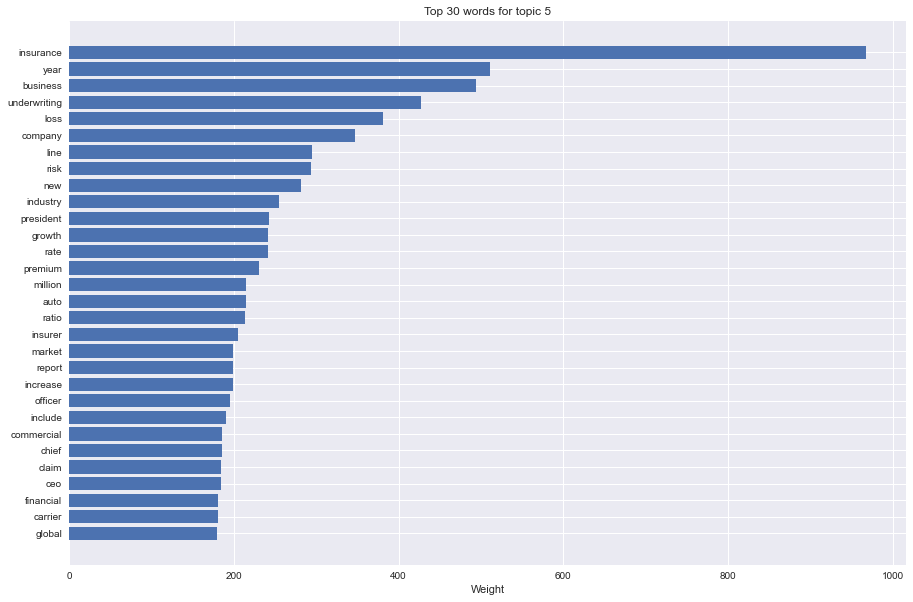

In [135]:
# Display the topic to word importance plot. Select the topic number.
topic_word_plot(5)

## Document-Topic Distribution

The `document-topic distribution (θ)` can be obtained by transforming your document-term matrix (dtm).

* The rows represent the documents.
* The columns represent the topics.
* The value at index (i, j) represents the **probability distribution of topics** for documents.

In [136]:
topic_results = LDA.transform(dtm)

In [137]:
df['topic'] = topic_results.argmax(axis=1)

In [138]:
df.head(5)

,article,clean_article,topic
0,Supreme Court Halts Purdue Pharma Bankruptcy S...,supreme court halt purdue pharma bankruptcy se...,8
1,Tutoring Firm Settles EEOC’s First Bias Lawsui...,tutor firm settle eeoc first bias lawsuit invo...,8
2,NOAA Increases Prediction for Atlantic Hurrica...,noaa increase prediction for atlantic hurrican...,3
3,Global Insurance M&A Drops Sharply in First Ha...,global insurance ma drop sharply in first half...,2
4,Political Violence in Polarized US at Its Wors...,political violence in polarize we at its bad s...,16


# Evaluate Model

## Perplexity

A common metric for probabilistic models, including LDA. Lower perplexity scores are generally better, indicating that the model is more confident in its predictions. However, it's worth noting that a lower perplexity does not always imply a better interpretable model.

**Lower perplexity scores are generally better**, indicating that the model is more confident in its predictions.

In [100]:
# Calculate Perplexity.
perplexity = LDA.perplexity(dtm)
print("Perplexity: ", perplexity)

Perplexity:  7641.888070022741


## Topic Coherence

Topic coherence scores, particularly the cv metric, typically range between 0 and 1. High coherence is closer to 1 and low coherence is closer to 0.

**High coherence scores are better**.

In [140]:
import gensim
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary

In [139]:
def calc_topic_coherence(topic_word_mat, df, vectorizer, top_n_words=10, coherence_type='c_v'):
    """
    Computes the coherence score for a trained LDA model from scikit-learn.

    Parameters:
    - topic_word_mat: Topic to word matrix
    - vectorizer: The CountVectorizer used to transform the documents.
    - documents: List of input texts/documents.
    - top_n_words: Number of top words to consider for each topic in coherence computation.
    - coherence_type: Type of coherence measure to use (e.g., 'c_v').

    Returns:
    - coherence_score: Coherence score for the LDA model.
    """
                  
    # Tokenize documents
    texts = [doc.split() for doc in df['clean_article']]

    # Create a Gensim dictionary and corpus
    dictionary = Dictionary(texts)
    corpus = [dictionary.doc2bow(text) for text in texts]

    # Get LDA topics
    topics = []

    for topic_idx, topic in enumerate(topic_word_mat):
        top_features_ind = topic.argsort()[-top_n_words:][::-1]
        top_features = [vectorizer.get_feature_names_out()[i] for i in top_features_ind]
        topics.append(top_features)

    # Compute Coherence Score using c_v
    coherence_model_lda = CoherenceModel(topics=topics, texts=texts, dictionary=dictionary, coherence=coherence_type)
    coherence_lda = coherence_model_lda.get_coherence()
    
    return coherence_lda

## Topic Diversity

The topic_diversity function will return a score between 0 and 1. Higher values indicate greater diversity between the topics.

**Higher diversity scores are better.**

In [114]:
def calc_topic_diversity(topic_word_mat):
    """
    Compute the topic diversity of a topic model based on the topic-word distributions.
    
    Args:
    - topic_word_mat (np.ndarray): Topic_word_distribution. 
                                   Matrix where each row is a topic and each column is a word. 
                                   The entry (i, j) is the weight of word j in topic i.
    
    Returns:
    - float: Topic diversity score
    """
    
    # sum(axis=1) sums all columns for each row.
    # [:, np.newaxis] converts 1D array into 2D column vector.
    # we are basically normalizing word-topic matrix.
    topic_word_distribution = topic_word_mat / topic_word_mat.sum(axis=1)[:, np.newaxis]
    
    # Compute pairwise cosine similarity
    similarities = cosine_similarity(topic_word_distribution)
    
    # Since cosine_similarity will return a value of 1 for the similarity of a topic with itself,
    # we subtract the identity matrix to set these values to 0
    similarities -= np.identity(similarities.shape[0])
    
    # Return the average similarity (or 1 - average similarity for diversity)
    return 1 - np.mean(similarities)

## Collect Evaluation Metric Scores

In [141]:
n_components = np.arange(5,21)

coherence_scores = []
diversity_scores = []
perplexity_scores = []

for n_component in n_components:
    
    # Create LDA and fit document-topic matrix
    LDA = LatentDirichletAllocation(n_components=n_component,random_state=42)
    LDA.fit(dtm)
    
    # Calculate scores for each N number of topics
    coh_score = calc_topic_coherence(LDA.components_, df, vectorizer, top_n_words=20)
    div_score = calc_topic_diversity(LDA.components_)
    
    # Collect scores
    coherence_scores.append(coh_score)
    diversity_scores.append(div_score)
    perplexity_scores.append(LDA.perplexity(dtm))

## Plot Results

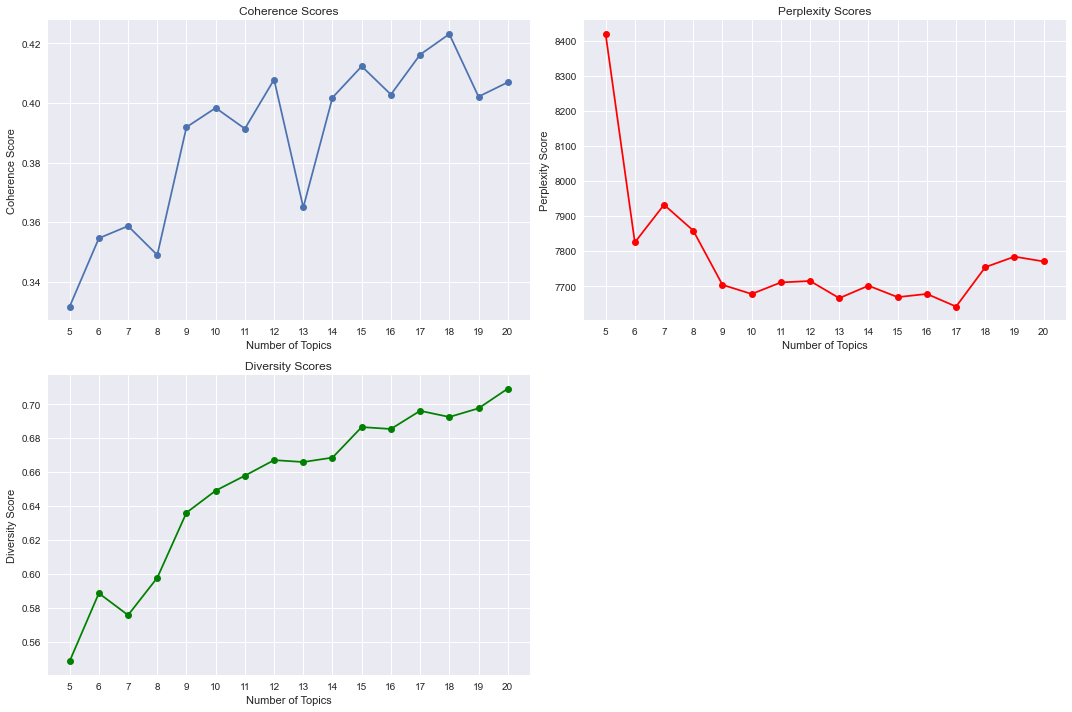

In [104]:
plt.figure(figsize=(15, 10))

start_topic = 5

# Assuming number of topics or some range
topics_range = list(range(start_topic, start_topic + len(coherence_scores)))  

# Coherence scores plot
plt.subplot(2, 2, 1)
plt.plot(topics_range, coherence_scores, marker='o')
plt.title("Coherence Scores")
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.xticks(topics_range)
plt.tight_layout()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Perplexity scores plot
plt.subplot(2, 2, 2)
plt.plot(topics_range, perplexity_scores, marker='o', color='r')
plt.title("Perplexity Scores")
plt.xlabel("Number of Topics")
plt.ylabel("Perplexity Score")
plt.xticks(topics_range)
plt.tight_layout()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Diversity scores plot
plt.subplot(2, 2, 3)
plt.plot(topics_range, diversity_scores, marker='o', color='g')
plt.title("Diversity Scores")
plt.xlabel("Number of Topics")
plt.ylabel("Diversity Score")
plt.xticks(topics_range)
plt.tight_layout()
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()

### From the graph, 17 numbers of topics seem reasonable!

In [149]:
df[df['topic'] == 1]['clean_article'].iloc[0]

'amazon again cite by regulator over worker safety \n the us workplace safety regulator say amazoncom inc have subject worker at yet another of its sprawl warehouse to hazardous condition by impose onerous production quota and fail to provide proper medical care \n the us department of labor occupational safety and health administration osha on thursday say worker at the logan township new jersey warehouse suffer bodily stress that be cause muscular disorder and neck and back injury and amazon fail to ensure that injure employee receive adequate treatment the agency say \n osha say it have recommend   in penalty which be the maximum fine allow under we law amazon have   day to either pay the fine or appeal to a review board \n since january osha have levy about   in fine on amazon for allegedly create hazardous condition or fail to record workrelated injury at several other warehouse across the country \n relate sander seek senate probe into amazons warehouse safety practice   amazon f

# K-mean Cluster on Topics

## Determine the Number of Clusters

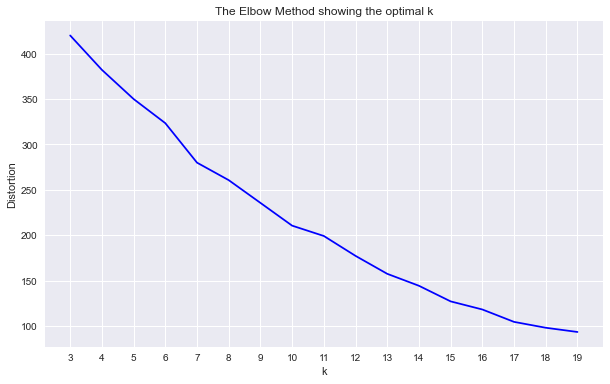

In [106]:
from sklearn.cluster import KMeans

distortions = []
K = range(3,20) 

for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(topic_results)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(10,6))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.xticks(K)
plt.title('The Elbow Method showing the optimal k')
plt.show()

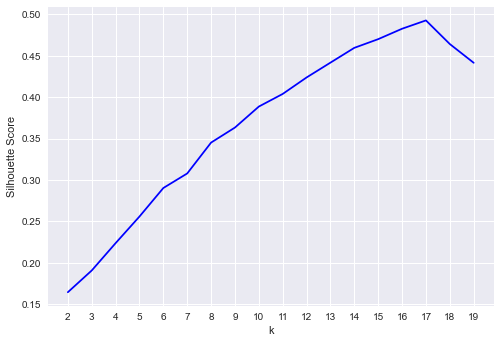

In [107]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2,20)  # Typically start from 2 because silhouette doesn't work with 1 cluster

for k in K:
    kmeans = KMeans(n_clusters=k)
    clusters = kmeans.fit_predict(topic_results)
    silhouette_avg = silhouette_score(topic_results, clusters)
    silhouette_scores.append(silhouette_avg)

plt.plot(K, silhouette_scores, 'bx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.xticks(K)
plt.show()